In [72]:
import os
import sys
import time
import numpy as np
import pandas as pd
import scipy as sp
from typing import List
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm, ticker
from astropy.io import fits
import astropy.io.ascii as astropy_ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

src_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src'
if not src_dir in sys.path: sys.path.append(src_dir)
utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

from step_7_fit_fp import fit_FP
from step_8_fit_logdist import fit_logdist

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
FP_SETTING = int(os.environ.get('FP_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))

# Check *ϵ* correlation with other variables

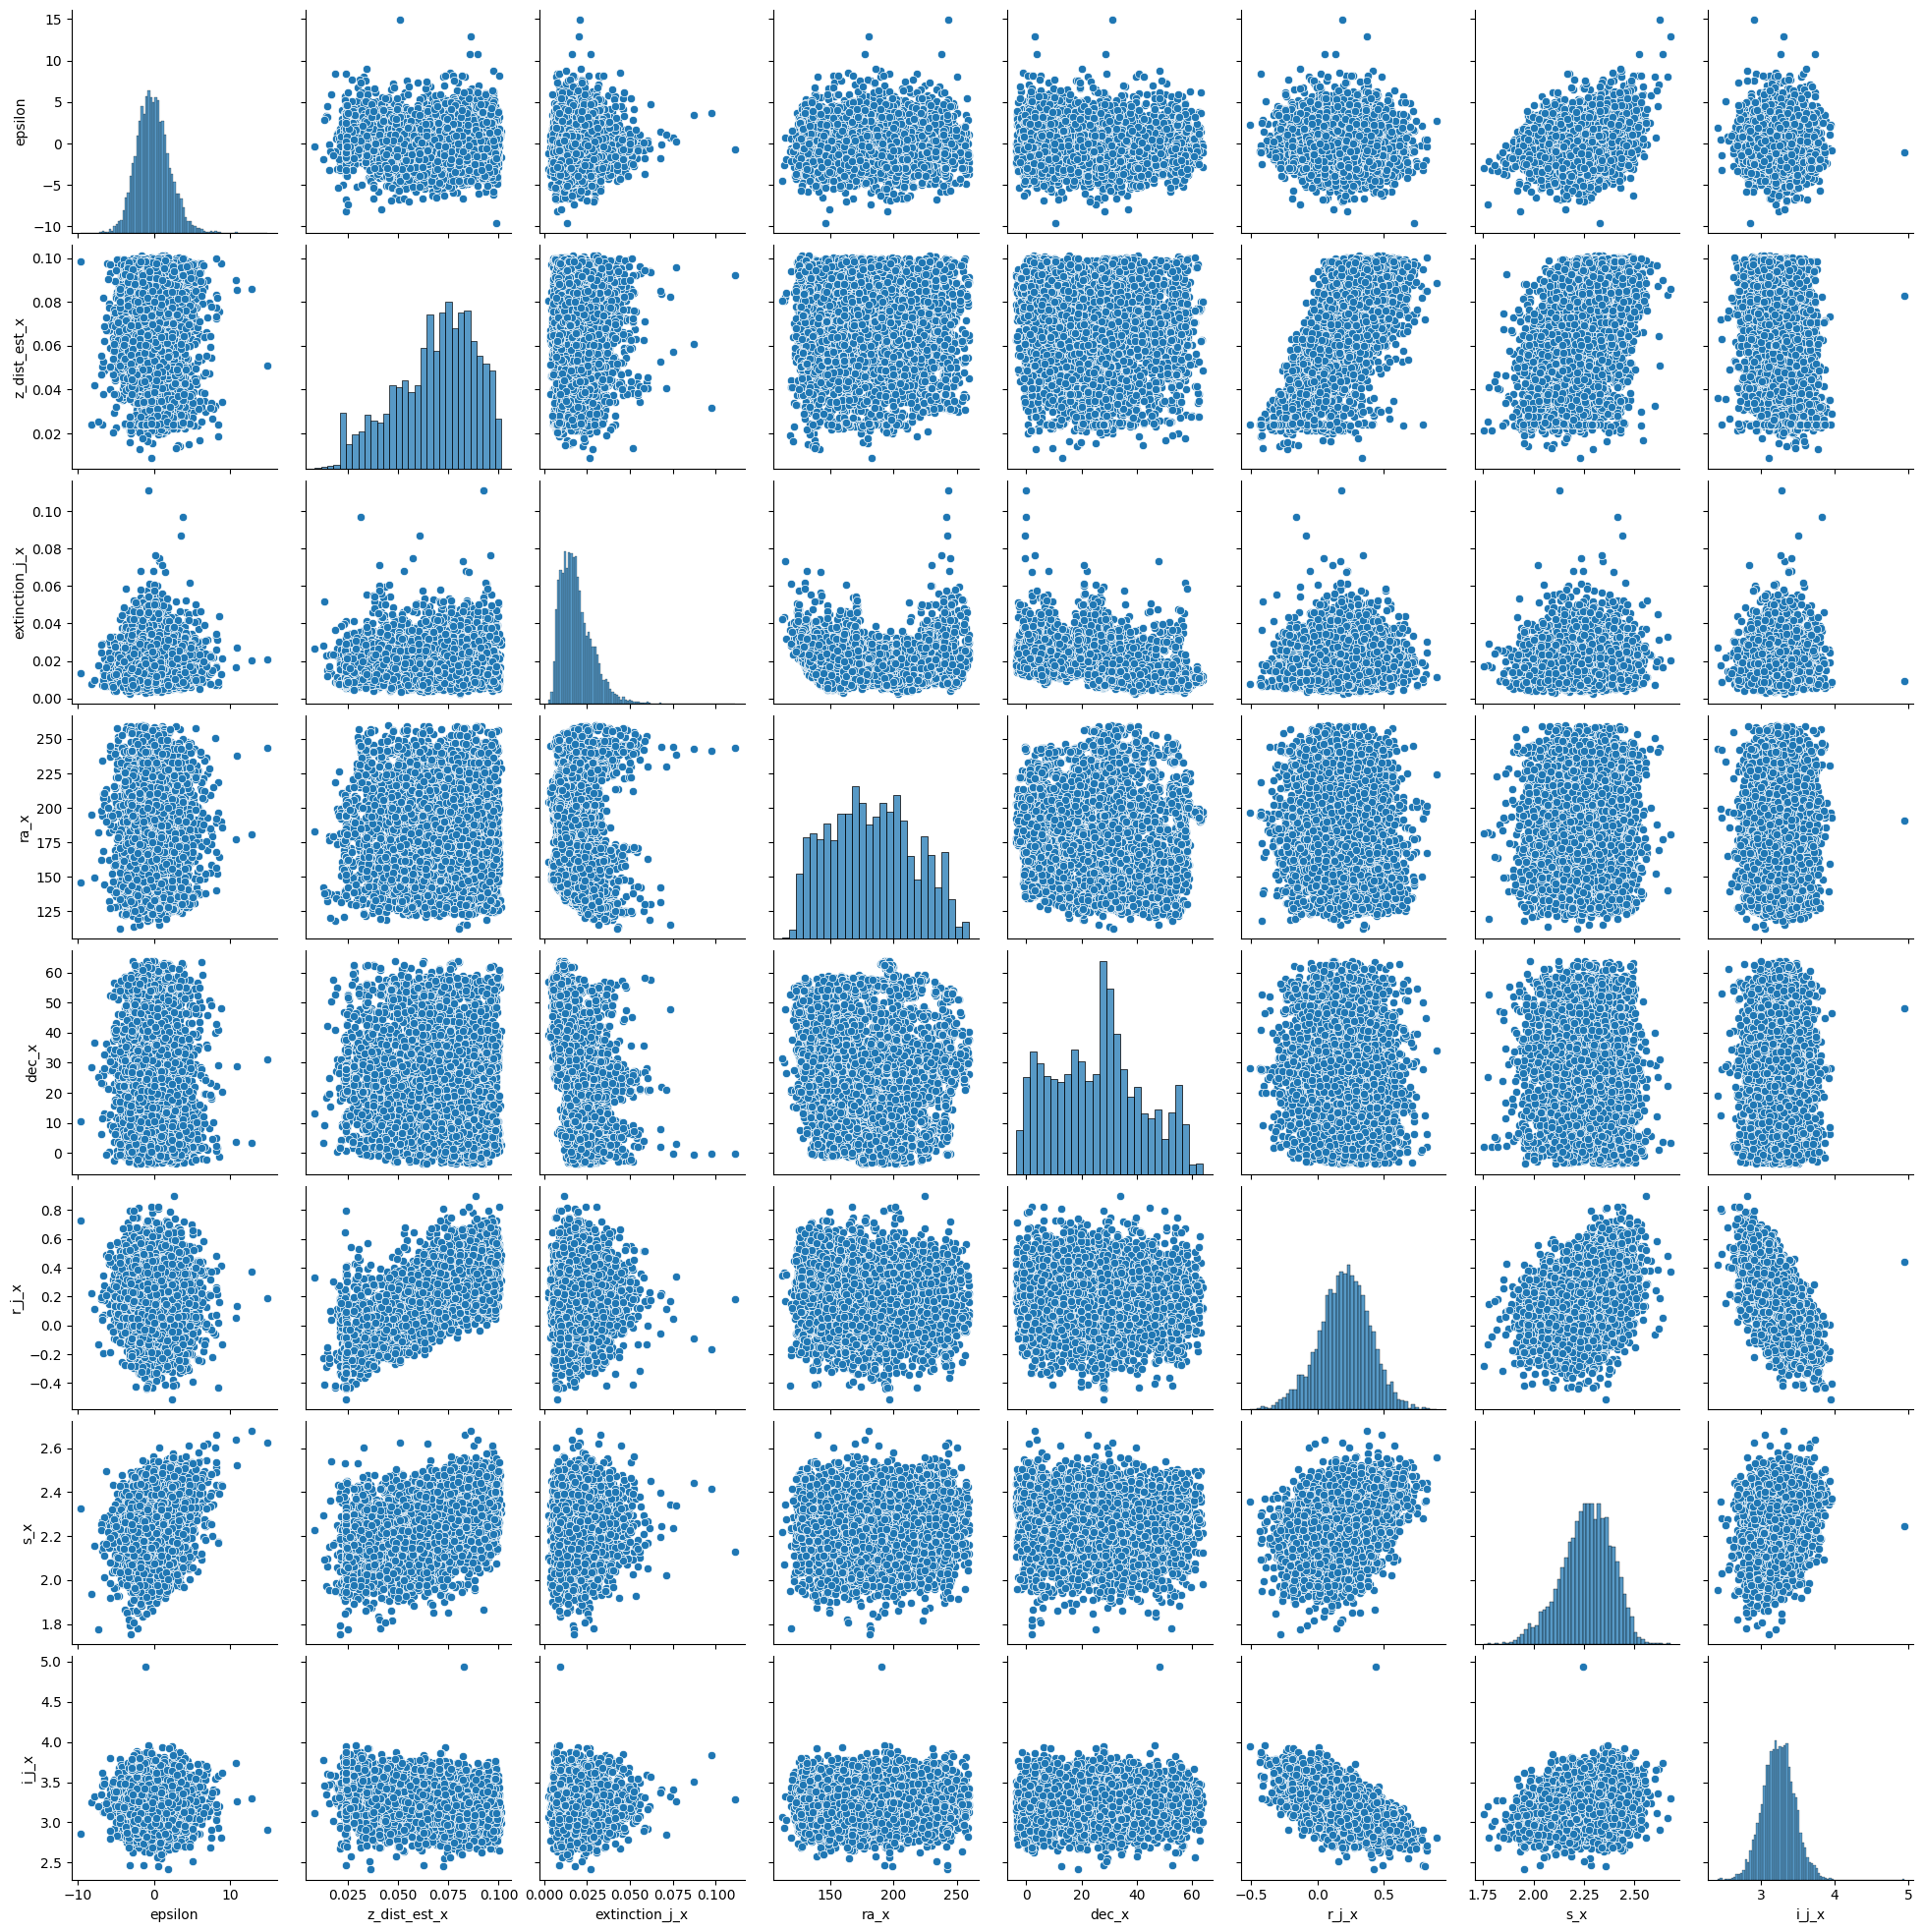

In [146]:
df_sdss = pd.read_csv('../data/processed/rsi_derived/sdss.csv')
df_lamost = pd.read_csv('../data/processed/rsi_derived/lamost.csv')

df = df_lamost.merge(df_sdss, on='tmass', how='inner')
# df = df_sdss.merge(df_lamost, on='tmass', how='inner')

df['epsilon'] = (df['s_x'] - df['s_y']) / np.sqrt(df['es_x']**2 + df['es_y']**2)

sns.pairplot(df[['epsilon', 'z_dist_est_x', 'extinction_j_x', 'ra_x', 'dec_x', 'r_j_x', 's_x', 'i_j_x']])

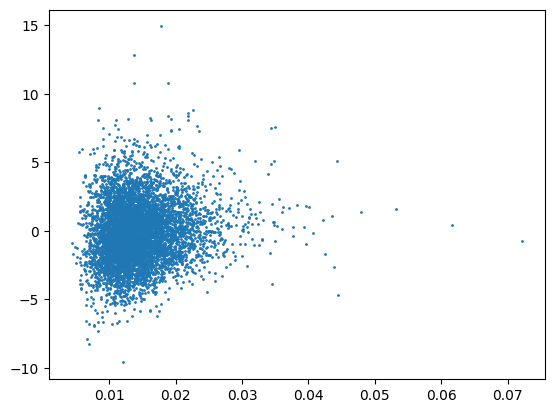

In [154]:
df['s_avg'] = 0.5 * (df['s_x'] + df['s_y'])

# plt.scatter(df['s_x'], df['epsilon'], s=1)
plt.scatter(df['es_y'], df['epsilon'], s=1)

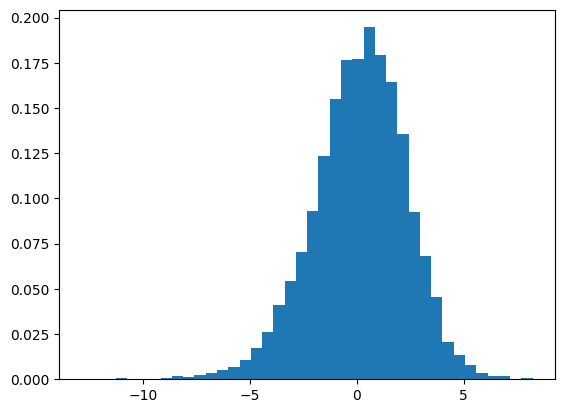

Comparison between sdss and lamost. Ngal = 6450...
- Mean of ϵ is 0.267 with standard error in the mean of 0.027. Therefore it is 9.757σ away from the expected 0.
- Std of ϵ is 2.199 with standard error in the std of 0.019. Therefore it is 61.916σ away from the expected 1.



In [74]:
# Load repeat measurement data
df_full = pd.read_csv('../data/processed/veldisp_calibrated/repeat_ori.csv')
# df_full['s_6df'] -= -0.022813061648683998
# df_full['s_lamost'] -= -0.0065238234688030396
# df_full['es_lamost'] *= 2.638063375565604

survey_combos = [('6df', 'sdss'), ('sdss', 'lamost'), ('6df', 'lamost')]
bins = [40]

for i, combo in enumerate([('sdss', 'lamost')]):
    survey_1, survey_2 = combo
    df = df_full.copy()
    
    # Calculate pairwise comparison
    df['epsilon'] = (df[f's_{survey_1}'] - df[f's_{survey_2}']) / np.sqrt(df[f'es_{survey_1}']**2 + df[f'es_{survey_2}']**2)
    
    # Remove outliers (1% and 99%)
    epsilon_upper = df['epsilon'].quantile(0.9999)
    epsilon_lower = df['epsilon'].quantile(0.0001)
    df = df[(df['epsilon'] <= epsilon_upper) & (df['epsilon'] >= epsilon_lower)]

    # Plot the histogram
    plt.figure()
    plt.hist(df['epsilon'], density=True, bins=bins[i])
    plt.show()
    
    # Calculate mean, std, and standard errors in them
    eps_mean = df['epsilon'].median()
    eps_std = df['epsilon'].std()
    eps_mean_stderr = eps_std / np.sqrt(len(df))
    eps_std_stderr = eps_std / np.sqrt(2 * (len(df) - 1))

    # Calculate severity
    mean_severity = np.absolute(eps_mean - 0.) / eps_mean_stderr
    std_severity = np.absolute(eps_std - 1.) / eps_std_stderr

    print(f"Comparison between {survey_1} and {survey_2}. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_mean, 3)} with standard error in the mean of {np.round(eps_mean_stderr, 3)}. Therefore it is {np.round(mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_std, 3)} with standard error in the std of {np.round(eps_std_stderr, 3)}. Therefore it is {np.round(std_severity, 3)}σ away from the expected 1.')
    print()

6dFGS 0.11489448051948041
SDSS 0.09495892304451754
LAMOST 0.0552763819095477


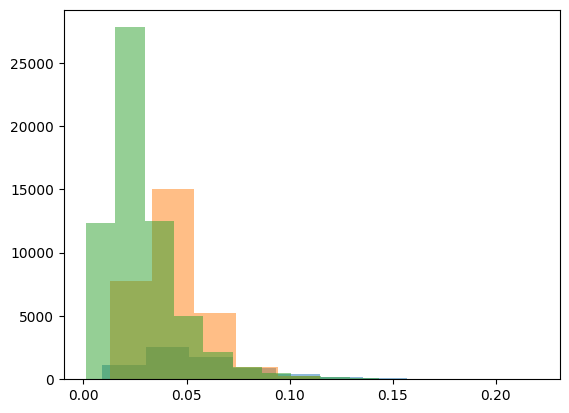

In [67]:
for survey in SURVEY_LIST:
    df = pd.read_csv(f'../data/processed/rsi_derived/{survey.lower()}.csv')
    if survey == 'SDSS':
        df['es'] *= 3
    print(survey, np.log(10) * df['es'].median())
    plt.hist(df['es'], alpha=0.5)

Generating comparison plot with the following inputs:
Method: lol
k_6df: 1.0
k_sdss: 1.0
k_lamost: 2.638063375565604
off_6df: -0.022813061648683998
off_sdss: 0.0
off_lamost: -0.0065238234688030396
Comparison between 6df and sdss before scaling. Ngal = 6534...
- Mean of ϵ is -0.562 with standard error in the mean of 0.103. Therefore it is -5.448σ away from the expected 0.
- Std of ϵ is 0.661 with standard error in the std of 0.074. Therefore it is 8.944σ away from the expected 1.
Comparison between 6df and sdss after scaling. Ngal = 6534...
- Mean of ϵ is -0.158 with standard error in the mean of 0.106. Therefore it is -1.494σ away from the expected 0.
- Std of ϵ is 0.679 with standard error in the std of 0.076. Therefore it is 8.944σ away from the expected 1.
Comparison between sdss and lamost before scaling. Ngal = 6534...
- Mean of ϵ is 0.267 with standard error in the mean of 0.028. Therefore it is 9.711σ away from the expected 0.
- Std of ϵ is 2.209 with standard error in the std o

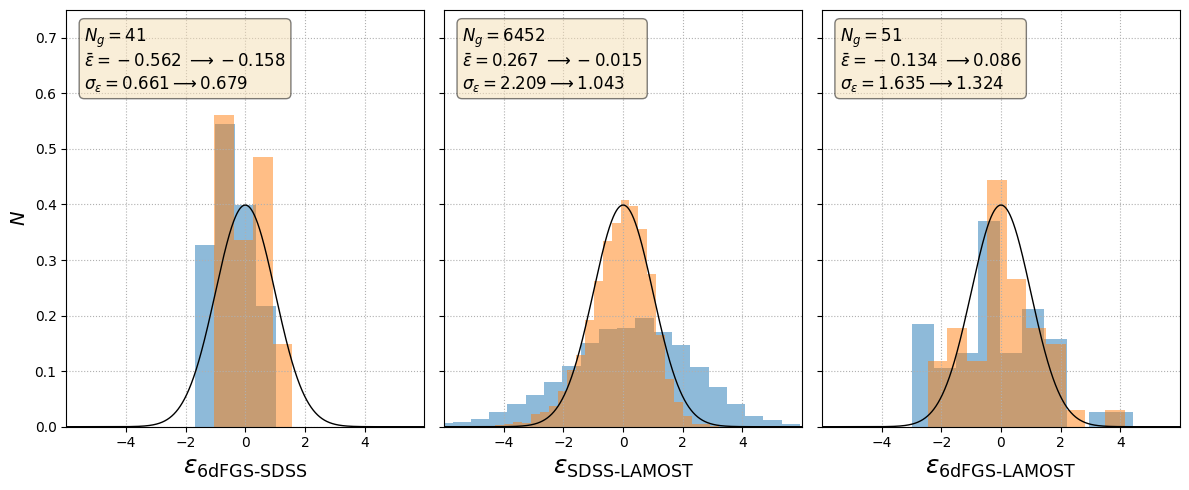

In [50]:
VELDISP_ORI_OUTPUT_FILEPATH = '../data/processed/veldisp_calibrated/repeat_ori.csv'

def generate_comparison_plot(method: str = 'lol', k_6df: float = 1.0, k_sdss: float = 1.0, k_lamost: float = 1.0, off_6df: float = 0.0, off_sdss: float = 0.0, off_lamost: float = 0.0, sigma_clip: float = 5.0) -> None:
    '''
    A function to generate the chi distributions histogram before vs after applying the calibrations.
    '''
    # CONSTANTS
    BIN_LIST = [4, 40, 10]
    XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
    SURVEY_COMBOS = [('6df', 'sdss'), ('sdss', 'lamost'), ('6df', 'lamost')]
    XLABEL_LIST = [r'$\epsilon_\text{6dFGS-SDSS}$', r'$\epsilon_\text{SDSS-LAMOST}$', r'$\epsilon_\text{6dFGS-LAMOST}$']

    off_6df = -0.022813061648683998
    k_6df = 1.0
    off_sdss = 0.0
    k_sdss = 1.0
    off_lamost = -0.0065238234688030396
    k_lamost = 2.638063375565604
    
    print('Generating comparison plot with the following inputs:')
    print(f'Method: {method}')
    print(f'k_6df: {k_6df}')
    print(f'k_sdss: {k_sdss}')
    print(f'k_lamost: {k_lamost}')
    print(f'off_6df: {off_6df}')
    print(f'off_sdss: {off_sdss}')
    print(f'off_lamost: {off_lamost}')

    df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
    # Apply the offsets
    df['s_6df_scaled'] = df['s_6df'] - off_6df
    df['es_6df_scaled'] = df['es_6df'] * k_6df
    df['s_sdss_scaled'] = df['s_sdss'] - off_sdss
    df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
    df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
    df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))
    
    for i, combo in enumerate(SURVEY_COMBOS):
        survey_1, survey_2 = combo
        
        # Calculate original statistics
        epsilon = (df[f's_{survey_1}'] - df[f's_{survey_2}']) / np.sqrt(df[f'es_{survey_1}']**2 + df[f'es_{survey_2}']**2)
        Ngal = epsilon.notna().sum()
        # Calculate mean, std, and standard errors in them
        eps_mean = epsilon.median()
        eps_std = epsilon.std()
        eps_mean_stderr = eps_std / np.sqrt(Ngal)
        eps_std_stderr = eps_std / np.sqrt(2 * (Ngal - 1))
        mean_severity = eps_mean / eps_mean_stderr
        std_severity = eps_std / eps_std_stderr
        
        print(f"Comparison between {survey_1} and {survey_2} before scaling. Ngal = {len(df)}...")
        print(f'- Mean of ϵ is {np.round(eps_mean, 3)} with standard error in the mean of {np.round(eps_mean_stderr, 3)}. Therefore it is {np.round(mean_severity, 3)}σ away from the expected 0.')
        print(f'- Std of ϵ is {np.round(eps_std, 3)} with standard error in the std of {np.round(eps_std_stderr, 3)}. Therefore it is {np.round(std_severity, 3)}σ away from the expected 1.')
        
        # Calculate statistics after scaling and offset
        epsilon_scaled = (df[f's_{survey_1}_scaled'] - df[f's_{survey_2}_scaled']) / np.sqrt(df[f'es_{survey_1}_scaled']**2 + df[f'es_{survey_2}_scaled']**2)
        Ngal_scaled = epsilon_scaled.notna().sum()
        # Calculate mean, std, and standard errors in them
        eps_scaled_mean = epsilon_scaled.median()
        eps_scaled_std = epsilon_scaled.std()
        eps_scaled_mean_stderr = eps_scaled_std / np.sqrt(Ngal_scaled)
        eps_scaled_std_stderr = eps_scaled_std / np.sqrt(2 * (Ngal_scaled - 1))
        scaled_mean_severity = eps_scaled_mean / eps_scaled_mean_stderr
        scaled_std_severity = eps_scaled_std / eps_scaled_std_stderr
        
        print(f"Comparison between {survey_1} and {survey_2} after scaling. Ngal = {len(df)}...")
        print(f'- Mean of ϵ is {np.round(eps_scaled_mean, 3)} with standard error in the mean of {np.round(eps_scaled_mean_stderr, 3)}. Therefore it is {np.round(scaled_mean_severity, 3)}σ away from the expected 0.')
        print(f'- Std of ϵ is {np.round(eps_scaled_std, 3)} with standard error in the std of {np.round(eps_scaled_std_stderr, 3)}. Therefore it is {np.round(scaled_std_severity, 3)}σ away from the expected 1.')
        
        axs[i].hist(epsilon, bins=BIN_LIST[i], density=True, alpha=0.5)
        axs[i].hist(epsilon_scaled, bins=BIN_LIST[i], density=True, alpha=0.5)
        
        # Write the before and after statistics
        textstr = '\n'.join((
            fr'$N_g = {Ngal}$',
            r'$\bar{\epsilon}=%.3f$' % eps_mean + fr' $\longrightarrow {np.round(eps_scaled_mean, 3)}$',
            fr'$\sigma_\epsilon={np.round(eps_std, 3)} \longrightarrow {np.round(eps_scaled_std, 3)}$'))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axs[i].text(-5.4, 0.72, textstr, fontsize=12,
                verticalalignment='top', bbox=props)
        
        # Misc
        axs[i].grid(linestyle=":")
        axs[i].set_xlim(XLIM_LIST[i])
        axs[i].set_ylim(0., 0.75)
        axs[i].set_xlabel(XLABEL_LIST[i], fontsize=18)
        axs[i].set_xticks(axs[i].get_xticks()[1:-1])
        axs[0].set_ylabel(r'$N$', fontsize=14)

    # Plot standard normal Gaussians (target)
    x = np.arange(start=-10., stop=10., step=0.0001)
    y = norm.pdf(x, loc=0., scale=1.)
    for ax in axs:
        ax.plot(x, y, c='k', lw=1.0)

    plt.subplots_adjust(wspace=0)

    img_output_path = os.path.join(ROOT_PATH, f'img/veldisp_comparison.pdf')
    print(f'Saving image to {img_output_path}')
    plt.tight_layout()
#         fig.savefig(img_output_path, dpi=300)

generate_comparison_plot()

In [1]:
# 2M++ Density and Peculiar Velocity Fields
# =========================================

# v1.0

# Please cite
# -----------
# Carrick et al. 15, MNRAS, in press.

# Coordinates
# -----------
# The density and peculiar velocity fields are both 257^3 cubes using
# the same coordinate system: configuration ("real") space
# (reconstructed so that the peculiar velocities are removed iteratively
# as described in Carrick et al 15), and smoothed with a Guassian of
# scale 4 Mpc/h.

# Specifically i,j,k index the 257^3 data cube in Galactic Cartesian
# comoving coordinates X,Y,Z in Mpc/h, with i running fastest. The cell
# centres run from -200 to 200 Mpc/h so the grid spacing is 1.5625 Mpc/h

# To convert Galactic X,Y,Z use:
# X = (i-128)*400./256.
# Y = (j-128)*400./256.
# Z = (k-128)*400./256.

# The centre of the cell [0,0,0] therefore corresponds to -200,-200,-200
# and the origin (Local Group) is in the centre of cell [128,128,128].

# The density delta_g^* is the luminosity-weighted density contrast.

# The velocities are predicted peculiar velocities in the CMB frame in
# Galactic Cartesian coordinates, generated from the delta_g* field with
# beta* = 0.43 and an external dipole Vext = [89,-131,17] (Carrick et al
# Table 3) has already been added.


# Sample Python 2.7 code to read 2M++ data

import numpy as np

# LG is in central voxel at 128,128,128
d = np.load('../data/external/velocity_model/twompp_density.npy')
print("Overdensity at LG is:", d[128,128,128])

v = np.load('../data/external/velocity_model/twompp_velocity.npy')

vlg = v[:,128,128,128]
print("LG's motion in Galactic:", vlg)
print("Velocity:", np.sqrt(vlg.dot(vlg)), "km/s")


Overdensity at LG is: 0.2918596514282739
LG's motion in Galactic: [  66.16449308 -576.26093721  402.53849541]
Velocity: 706.0394098033505 km/s


In [144]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

# Assuming your data is loaded into the 'data' variable
data = v  # Replace this with your actual data

# Create the grid
x = np.linspace(0, 256, 257)
y = np.linspace(0, 256, 257)
z = np.linspace(0, 256, 257)

# Create the interpolators for each component
interpolator_x = RegularGridInterpolator((x, y, z), data[0])
interpolator_y = RegularGridInterpolator((x, y, z), data[1])
interpolator_z = RegularGridInterpolator((x, y, z), data[2])



# Specify the point of interest
X_0, Y_0, Z_0 = 128.0, 128.0, 128.9  # Replace with your desired coordinates

# Interpolate the values
point = [X_0, Y_0, Z_0]
value_x = interpolator_x(point)
value_y = interpolator_y(point)
value_z = interpolator_z(point)

# Combine the results into a vector
vector_value = np.array([value_x, value_y, value_z])

print("The interpolated vector value at (X_0, Y_0, Z_0) is:", vector_value)


The interpolated vector value at (X_0, Y_0, Z_0) is: [[  75.79519768]
 [-599.72082301]
 [ 465.2560706 ]]


In [145]:
v[:, 128, 128, 129]

array([  76.86527596, -602.32747698,  472.22469007])

In [174]:
df = pd.read_csv('../artifacts/veldisp_calibration/totoffs.csv')

# 1/(10 ** df)
df['off_6df']
# df['off_6df'].std()
# plt.hist(df['off_6df'])
# plt.hist(df['off_lamost'])


0    -0.022813
1    -0.020617
2    -0.004593
3    -0.002233
4    -0.018022
        ...   
95   -0.017244
96   -0.016473
97   -0.021575
98   -0.020171
99   -0.037436
Name: off_6df, Length: 100, dtype: float64

In [177]:
np.log(10) * df['off_6df'].std() * (10 ** -df['off_6df'].loc[0])

0.023693779500762385

In [178]:
np.log(10) * df['off_lamost'].std() * (10 ** -df['off_lamost'].loc[0])

0.0020271815461481253

In [180]:
10 ** 2.072031084318865

118.04051192856994